In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Image related
import cv2
from PIL import Image

# For ploting
import matplotlib.pyplot as plt

# For the model and it's training
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib

In [16]:
import os
from PIL import Image
import numpy as np
import pandas as pd

# Define paths
train_path = '/content/drive/My Drive/Traffic sign recognition/GTSRB/Train'
test_path = '/content/drive/My Drive/Traffic sign recognition/GTSRB/Test'
test_csv = '/content/drive/My Drive/Traffic sign recognition/GTSRB/Test.csv'

# Initialize lists for storing training data and labels
train_data = []
train_labels = []
test_data = []
test_labels = []
classes = 43  # Number of classes in the dataset

# Load Training Data
for i in range(classes):
    class_path = os.path.join(train_path, str(i))  # Path to each class folder
    images = os.listdir(class_path)  # List all images in the class folder

    for img_name in images:
        try:
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)  # Open each image
            image = image.resize((30, 30))  # Resize image to 30x30 pixels
            image = np.array(image)  # Convert image to NumPy array
            train_data.append(image)  # Add image data to the list
            train_labels.append(i)  # Add the corresponding label (class)
        except Exception as e:
            print(f"Error loading image {img_name} from {class_path}: {e}")

# Convert lists to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print(f"Train Data shape: {train_data.shape}, Train Labels shape: {train_labels.shape}")

Train Data shape: (39209, 30, 30, 3), Train Labels shape: (39209,)


In [18]:
# Load Test Data and Corresponding Labels from Test.csv
# Read the test labels from the CSV file
test_labels_df = pd.read_csv(test_csv)

# Iterate over each row in the CSV file
for idx, row in test_labels_df.iterrows():
    img_name = row['Path']
    img_name = img_name.replace("Test/", "") # remove the test prefix
    label = row['ClassId']

    img_path = os.path.join(test_path, img_name)

    try:
        image = Image.open(img_path)  # Open the image
        image = image.resize((30, 30))  # Resize image to 30x30 pixels
        image = np.array(image)  # Convert image to NumPy array
        test_data.append(image)  # Add image data to the test list
        test_labels.append(label)  # Add the corresponding label
    except Exception as e:
        print(f"Error loading image {img_name} from {test_path}: {e}")

# Convert test lists to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(f"Test Data shape: {test_data.shape}, Test Labels shape: {test_labels.shape}")

# Normalize the image data (optional but recommended)
X_train = train_data / 255.0
X_test = test_data / 255.0

Test Data shape: (16325, 30, 30, 3), Test Labels shape: (16325,)


In [19]:
# Function to one-hot encode labels
def one_hot_encode(labels, num_classes):
    return to_categorical(labels, num_classes)

# One-hot encoding for labels
y_train = one_hot_encode(train_labels, 43)
y_test = one_hot_encode(test_labels, 43)

# Displaying the shape after one-hot encoding
print(f"One-hot encoded train labels shape: {y_train.shape}")
print(f"One-hot encoded test labels shape: {y_test.shape}")

One-hot encoded train labels shape: (39209, 43)
One-hot encoded test labels shape: (16325, 43)


In [20]:
# Build the model
model = Sequential()

# First conv block with BatchNormalization
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:], kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second conv block with BatchNormalization
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Fully connected layers with dropout
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.3))

# Output layer
model.add(Dense(43, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 22, 22, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 22, 22, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 9, 9, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 9, 9, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,947 (437.29 KB)

 Trainable params: 111,563 (435.79 KB)

 Non-trainable params: 384 (1.50 KB)

In [21]:
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# Optionally stop training early if validation accuracy stops improving
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

In [22]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20,
                    validation_data=(X_test, y_test),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5624 - loss: 1.8199 - val_accuracy: 0.9128 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 2/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9655 - loss: 0.3559 - val_accuracy: 0.9147 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 3/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9773 - loss: 0.2765 - val_accuracy: 0.9531 - val_loss: 0.3535 - learning_rate: 0.0010
Epoch 4/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9833 - loss: 0.2357 - val_accuracy: 0.9638 - val_loss: 0.3007 - learning_rate: 0.0010
Epoch 5/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9781 - loss: 0.2457 - val_accuracy: 0.9606 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 6/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9808 - loss: 0.2310 - val_accuracy: 0.9458 - val_loss: 0.3622 - learning_rate: 0.0010
Epoch 7/20
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9842 

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9863 - loss: 0.1094
Test Loss: 0.10826507955789566
Test Accuracy: 0.986952543258667


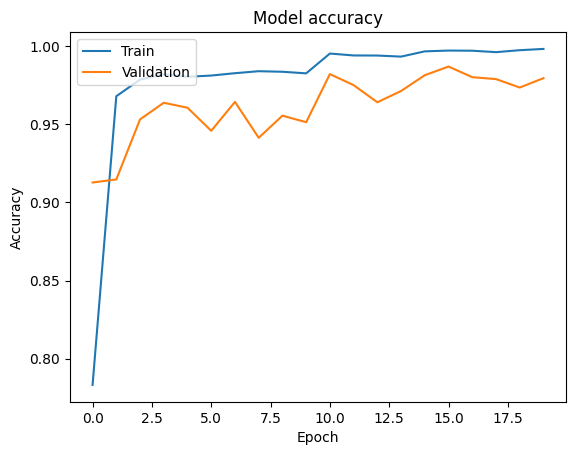

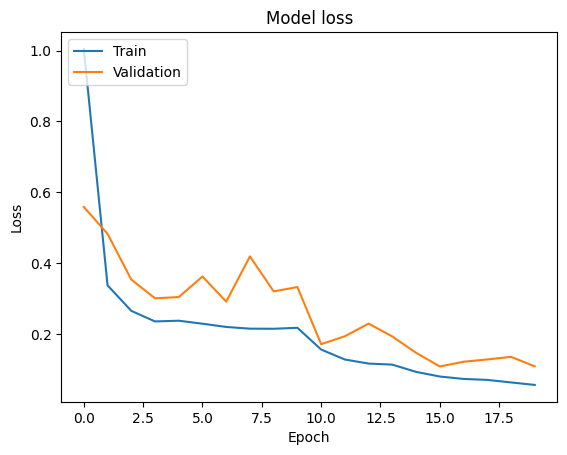

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
model.save('traffic_sign_model.h5')

In [25]:
model.save('/content/drive/My Drive/Traffic sign recognition/GTSRB/traffic_sign_model.keras')

In [26]:
model.save('/content/drive/My Drive/Traffic sign recognition/GTSRB/traffic_sign_model.h5')